In [5]:
#データ準備

import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
 
train_raw = pd.read_csv('train.csv') #学習データ
test_raw = pd.read_csv('test.csv') #テストデータ
print('The size of the train data:' + str(train_raw.shape))
print('The size of the test data:' + str(test_raw.shape))

The size of the train data:(891, 12)
The size of the test data:(418, 11)


In [6]:

# 学習データとテストデータのマージ
train_mid = train_raw.copy()
test_mid = test_raw.copy()
train_mid['train_or_test'] = 'train'#学習データフラグ
test_mid['train_or_test'] = 'test' #テストデータフラグ
test_mid['Survived'] = 9 #テストにSurvivedカラムを仮置き
 
alldata = pd.concat(
    [
        train_mid,
        test_mid
    ],
    sort=False,
    axis=0
).reset_index(drop=True)


In [7]:
#カラムの名前確認

#print("columns : "+ str(train_raw.keys))
print("columns : "+str(train_raw.columns))

#統計量確認

test_raw.describe()
train_raw.describe()


columns : Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
#平均生存率
train_raw['Survived'].mean()

0.3838383838383838

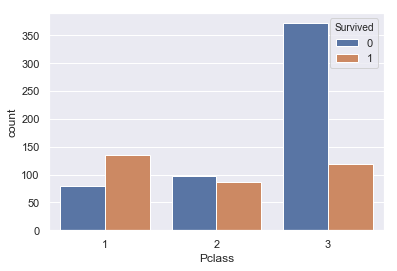

In [9]:

sns.countplot(train_raw['Pclass'], hue=train_raw['Survived'])

Pclass1の乗客は生存率が高く、3の乗客の生存率は低い結果となった。（これはtitanic_modelのほうでも同じ結果である。）

In [10]:
#Nameの確認
train_raw['Name'].head(10)


0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [11]:
alldata['honorific'] = alldata['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
pd.crosstab(alldata['honorific'],alldata['train_or_test']) #敬称別のレコード数

train_or_test,test,train
honorific,,
Capt,0,1
Col,2,2
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,0,1
Major,0,2
Master,21,40


In [53]:
# 学習データにしか現れない敬称を除外
only_train_honorific = ['Capt','Don','Jonkheer','Lady','Major','Mile','Mme','Sir','the Countess']
train_omit1 = train_raw[~train_raw['honorific'].isin(only_train_honorific) ].reset_index(drop=True)
# 敬称別の生存率とレコード数
train_omit1['Survived'].groupby(train_omit1['honorific']).agg(['mean','count'])

KeyError: 'honorific'

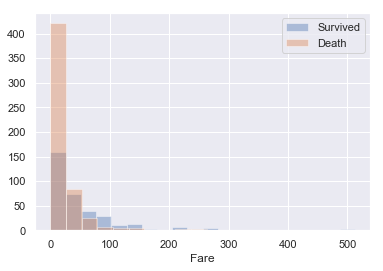

In [13]:
# Fareの分布
sns.distplot(train_raw[train_raw['Survived']==1]['Fare'],kde=False,rug=False,bins=20,label='Survived')
sns.distplot(train_raw[train_raw['Survived']==0]['Fare'],kde=False,rug=False,bins=10,label='Death')
plt.legend()

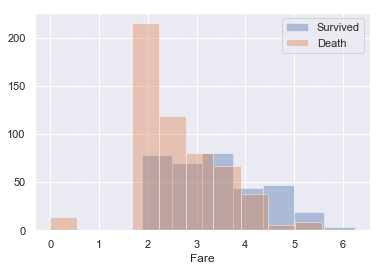

In [14]:

# 分布が歪んでいるためFareを対数変換して再度分布を確認
sns.distplot(np.log1p(train_raw[train_raw['Survived']==1]['Fare']),kde=False,rug=False,bins=10,label='Survived')
sns.distplot(np.log1p(train_raw[train_raw['Survived']==0]['Fare']),kde=False,rug=False,bins=10,label='Death')
plt.legend()

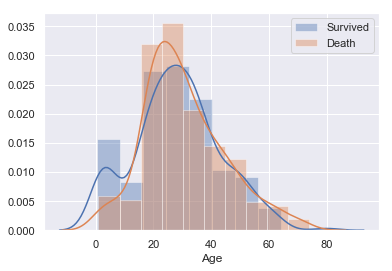

In [15]:
# Ageの欠損を除外
train_age_omit = train_raw.dropna(subset=['Age'])
# Ageの分布
sns.distplot(train_age_omit[train_age_omit['Survived']==1]['Age'],kde=True,rug=False,bins=10,label='Survived') #生存者の分布
sns.distplot(train_age_omit[train_age_omit['Survived']==0]['Age'],kde=True,rug=False,bins=10,label='Death') #死者の分布
plt.legend()

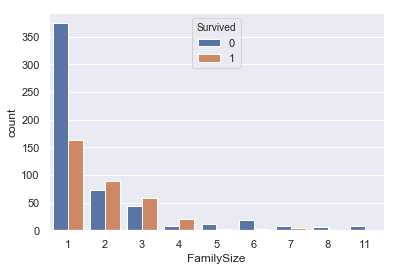

In [16]:
# 家族数 = Parch + SibSp + 1
train_raw['FamilySize'] = train_raw['Parch'] + train_raw['SibSp'] + 1 #学習データ
alldata['FamilySize'] = alldata['Parch'] + alldata['SibSp'] + 1 #ALLデータ
# 家族数ごとの分布を確認
sns.countplot(train_raw['FamilySize'],hue=train_raw['Survived'])

1人で乗船した人は生存率が低く、2，3，4人で乗船した人は生存率が高い。

In [17]:
# Cabinの頭文字
train_raw['Cabin_ini'] = train_raw['Cabin'].map(lambda x:str(x)[0])
alldata['Cabin_ini'] = alldata['Cabin'].map(lambda x:str(x)[0])
# Cabinの頭文字別の生存率とレコード数
train_raw['Survived'].groupby(train_raw['Cabin_ini']).agg(['mean','count'])

# Cabinの頭文字別のカウント数
pd.crosstab(alldata['Cabin_ini'],alldata['train_or_test'])


train_or_test,test,train
Cabin_ini,,
A,7,15
B,18,47
C,35,59
D,13,33
E,9,32
F,8,13
G,1,4
T,0,1
n,327,687


In [18]:
train_raw['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [19]:

# 欠損値補完
alldata.isnull().sum()

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age               263
SibSp               0
Parch               0
Ticket              0
Fare                1
Cabin            1014
Embarked            2
train_or_test       0
honorific           0
FamilySize          0
Cabin_ini           0
dtype: int64

In [20]:

# Embarkedには最頻値を代入
alldata.Embarked.fillna(alldata.Embarked.mode()[0], inplace=True)
# Fareには中央値を代入
alldata.Fare.fillna(alldata.Fare.median(), inplace=True)
# 欠損値補完がされたかを確認
print(alldata.isnull().sum())

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age               263
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin            1014
Embarked            0
train_or_test       0
honorific           0
FamilySize          0
Cabin_ini           0
dtype: int64


In [21]:
alldata.dtypes

PassengerId        int64
Survived           int64
Pclass             int64
Name              object
Sex               object
Age              float64
SibSp              int64
Parch              int64
Ticket            object
Fare             float64
Cabin             object
Embarked          object
train_or_test     object
honorific         object
FamilySize         int64
Cabin_ini         object
dtype: object

In [22]:
alldata.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_or_test',
       'honorific', 'FamilySize', 'Cabin_ini'],
      dtype='object')

In [24]:

# Fareの分割
alldata.loc[:, 'Fare_bin'] = pd.qcut(alldata.Fare, 10)

In [25]:
alldata.dtypes

PassengerId         int64
Survived            int64
Pclass              int64
Name               object
Sex                object
Age               float64
SibSp               int64
Parch               int64
Ticket             object
Fare              float64
Cabin              object
Embarked           object
train_or_test      object
honorific          object
FamilySize          int64
Cabin_ini          object
Fare_bin         category
dtype: object

In [ ]:
先ほど相関がありそうだった、家族数を離散化してカラムに追加。

In [27]:
# Familysize
alldata['FamilySize'] = alldata['Parch'] + alldata['SibSp'] + 1 #ALLデータ
# FamilySizeを離散化
alldata['FamilySize_bin'] = 'big'
alldata.loc[alldata['FamilySize']==1,'FamilySize_bin'] = 'alone'
alldata.loc[(alldata['FamilySize']>=2) & (alldata['FamilySize']<=4),'FamilySize_bin'] = 'small'
alldata.loc[(alldata['FamilySize']>=5) & (alldata['FamilySize']<=7),'FamilySize_bin'] = 'mediam'

In [ ]:
先ほど相関がありそうだった、チケット頻度をカラムに追加。

In [28]:
#チケットの頻度
alldata.loc[:, 'TicketFreq'] = alldata.groupby(['Ticket'])['PassengerId'].transform('count')

In [ ]:
先ほど相関がありそうだった、敬称ｗｌカラムに追加。

In [29]:

# Cabinの頭文字
alldata['Cabin_ini'] = alldata['Cabin'].map(lambda x:str(x)[0])
alldata['Cabin_ini'].replace(['G','T'], 'Rare',inplace=True) #少数派のCabin_iniを統合

In [30]:
alldata.dtypes

PassengerId          int64
Survived             int64
Pclass               int64
Name                object
Sex                 object
Age                float64
SibSp                int64
Parch                int64
Ticket              object
Fare               float64
Cabin               object
Embarked            object
train_or_test       object
honorific           object
FamilySize           int64
Cabin_ini           object
Fare_bin          category
FamilySize_bin      object
TicketFreq           int64
dtype: object

In [31]:

alldata.Pclass = alldata.Pclass.astype('str')

In [32]:
alldata.dtypes

PassengerId          int64
Survived             int64
Pclass              object
Name                object
Sex                 object
Age                float64
SibSp                int64
Parch                int64
Ticket              object
Fare               float64
Cabin               object
Embarked            object
train_or_test       object
honorific           object
FamilySize           int64
Cabin_ini           object
Fare_bin          category
FamilySize_bin      object
TicketFreq           int64
dtype: object

In [36]:

# カテゴリ特徴量についてlabel encoding
from sklearn.preprocessing import LabelEncoder

le_target_col = ['Sex', 'Fare_bin']
le = LabelEncoder()
for col in le_target_col:
    alldata.loc[:, col] = le.fit_transform(alldata[col])

In [38]:
alldata.dtypes

PassengerId         int64
Survived            int64
Pclass             object
Name               object
Sex                 int32
Age               float64
SibSp               int64
Parch               int64
Ticket             object
Fare              float64
Cabin              object
Embarked           object
train_or_test      object
honorific          object
FamilySize          int64
Cabin_ini          object
Fare_bin            int32
FamilySize_bin     object
TicketFreq          int64
dtype: object

In [39]:
# カテゴリカル変数をOne-Hot Encoding
cat_col = ['Pclass', 'Embarked','honorific','Cabin_ini', 'FamilySize_bin', 'Fare_bin']
alldata = pd.get_dummies(alldata, drop_first=True, columns=cat_col)

In [40]:
alldata.columns

Index(['PassengerId', 'Survived', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'train_or_test', 'FamilySize', 'TicketFreq',
       'Pclass_2', 'Pclass_3', 'Embarked_Q', 'Embarked_S', 'honorific_Col',
       'honorific_Don', 'honorific_Dona', 'honorific_Dr', 'honorific_Jonkheer',
       'honorific_Lady', 'honorific_Major', 'honorific_Master',
       'honorific_Miss', 'honorific_Mlle', 'honorific_Mme', 'honorific_Mr',
       'honorific_Mrs', 'honorific_Ms', 'honorific_Rev', 'honorific_Sir',
       'honorific_the Countess', 'Cabin_ini_B', 'Cabin_ini_C', 'Cabin_ini_D',
       'Cabin_ini_E', 'Cabin_ini_F', 'Cabin_ini_Rare', 'Cabin_ini_n',
       'FamilySize_bin_big', 'FamilySize_bin_mediam', 'FamilySize_bin_small',
       'Fare_bin_1', 'Fare_bin_2', 'Fare_bin_3', 'Fare_bin_4', 'Fare_bin_5',
       'Fare_bin_6', 'Fare_bin_7', 'Fare_bin_8', 'Fare_bin_9'],
      dtype='object')

In [41]:
alldata.dtypes

PassengerId                 int64
Survived                    int64
Name                       object
Sex                         int32
Age                       float64
SibSp                       int64
Parch                       int64
Ticket                     object
Fare                      float64
Cabin                      object
train_or_test              object
FamilySize                  int64
TicketFreq                  int64
Pclass_2                    uint8
Pclass_3                    uint8
Embarked_Q                  uint8
Embarked_S                  uint8
honorific_Col               uint8
honorific_Don               uint8
honorific_Dona              uint8
honorific_Dr                uint8
honorific_Jonkheer          uint8
honorific_Lady              uint8
honorific_Major             uint8
honorific_Master            uint8
honorific_Miss              uint8
honorific_Mlle              uint8
honorific_Mme               uint8
honorific_Mr                uint8
honorific_Mrs 

特徴量作成完了
以下より教師データとテストデータの分割

In [43]:
#教師データとテストデータを分割

from sklearn.model_selection import train_test_split
 
# 最初に統合したtrainとtestを分離
train = alldata.query('train_or_test == "train"')
test = alldata.query('train_or_test == "test"')
# ターゲット変数と、学習に不要なカラムを定義
target_col = 'Survived'
drop_col = ['PassengerId','Survived', 'Name', 'Fare', 'Ticket', 'Cabin', 'train_or_test', 'Age', 'Parch', 'FamilySize', 'SibSp']
# 学習に必要な特徴量のみを保持
train_feature = train.drop(columns=drop_col)
test_feature = test.drop(columns=drop_col)
train_tagert = train[target_col]
# trainデータを分割
X_train, X_test, y_train, y_test = train_test_split(
    train_feature, train_tagert, test_size=0.2, random_state=0, stratify=train_tagert)

In [46]:
X_train.dtypes

Sex                       int32
TicketFreq                int64
Pclass_2                  uint8
Pclass_3                  uint8
Embarked_Q                uint8
Embarked_S                uint8
honorific_Col             uint8
honorific_Don             uint8
honorific_Dona            uint8
honorific_Dr              uint8
honorific_Jonkheer        uint8
honorific_Lady            uint8
honorific_Major           uint8
honorific_Master          uint8
honorific_Miss            uint8
honorific_Mlle            uint8
honorific_Mme             uint8
honorific_Mr              uint8
honorific_Mrs             uint8
honorific_Ms              uint8
honorific_Rev             uint8
honorific_Sir             uint8
honorific_the Countess    uint8
Cabin_ini_B               uint8
Cabin_ini_C               uint8
Cabin_ini_D               uint8
Cabin_ini_E               uint8
Cabin_ini_F               uint8
Cabin_ini_Rare            uint8
Cabin_ini_n               uint8
FamilySize_bin_big        uint8
FamilySi

C:\Users\takes\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Text(0.5, 1.0, 'RandomForestClassifier feature importance')

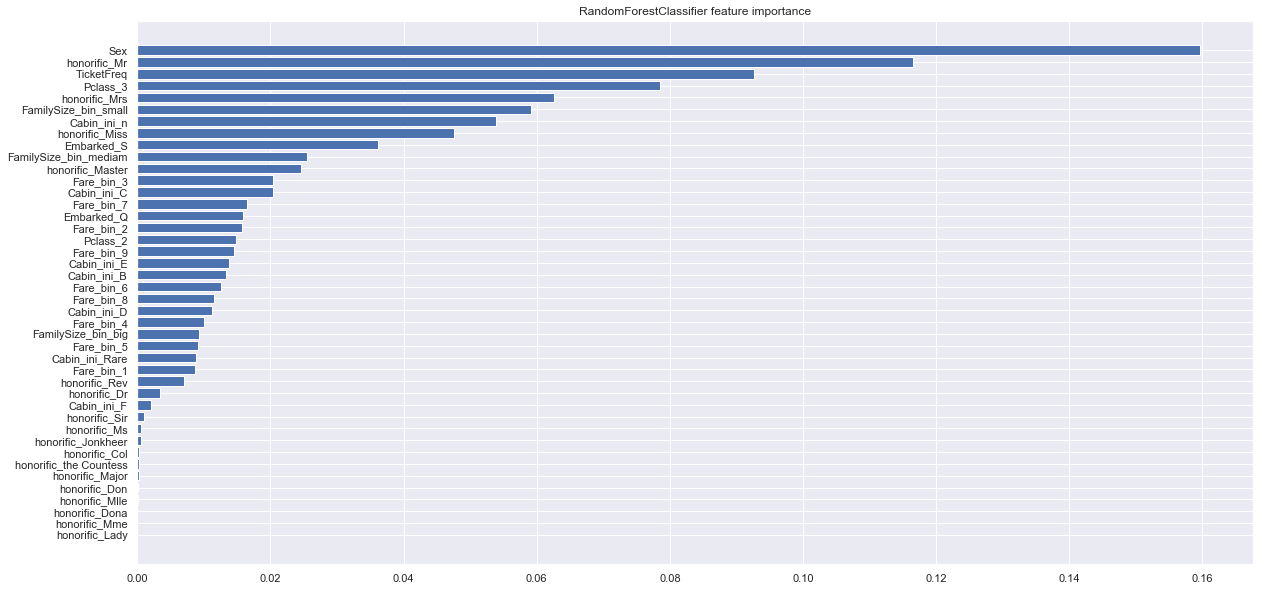

In [48]:
# ランダムフォレストで重要度を可視化する

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)


plt.figure(figsize=(20,10))
plt.barh(
    X_train.columns[np.argsort(rfc.feature_importances_)],
    rfc.feature_importances_[np.argsort(rfc.feature_importances_)],
    label='RandomForestClassifier'
)
plt.title('RandomForestClassifier feature importance')

In [51]:

# RandomForest
rfc_best = RandomForestClassifier(random_state=0)
rfc_best.fit(train_feature, train_tagert)

# 推論
pred = {
    'rfc': rfc_best.predict(test_feature),
}
# ファイル出力
for key, value in pred.items():
    pd.concat(
        [
            pd.DataFrame(test.PassengerId, columns=['PassengerId']).reset_index(drop=True),
            pd.DataFrame(value, columns=['Survived'])
        ],
        axis=1
    ).to_csv(f'my_{key}_two.csv', index=False)

C:\Users\takes\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


識別率　78.5%
